# RSS similarity experiment #

The code below recreates Figure 2 from the paper "Spectrally approximating large graphs with smaller graphs" submitted to ICML.

Depedencies: [pygsp](https://pygsp.readthedocs.io/en/stable/), matplotlib, numpy, scipy

In [6]:
from coarsening_utils import *

import matplotlib.pylab as plt
%matplotlib notebook

import numpy as np
import pygsp as gsp
from pygsp import graphs, filters
gsp.plotting.BACKEND = 'matplotlib'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
from scipy import io
from scipy.linalg import circulant

The parameters below are meant to facilitate a quick inspection of the code. 

To recreate the experiment of the paper: 
- select the graph type from: 'swissroll', 'bunny', 'regular', 'yeast'
- set N respectively to: 1000, 1000, 400, 1458
- set r respectively to: 0.4, 0.4, 0.4, 0.25
- set iterations to 10

For the yeast network, please first run the "preprocess_yeast_network" script.

In [20]:
# Experiment parameters
iterations = 1
N          = 400
r          = 0.4
p_success  = np.array([0.5, 0.7])
graph_name = 'regular'

# Metrics of interest
rss       = np.zeros((N, iterations))
bound_rss = np.ones(( N, iterations, len(p_success))) + np.NaN
 
for iteration in range(0, iterations):
                
    # ---------------------------------------------
    # construct the graph
    # ---------------------------------------------
    tries = 0
    while True:
        tries = tries + 1
        if graph_name == 'swissroll':
            if N != 1000: print('WARNING: Set N to 1000 and rerun'); break 
            G = graphs.SwissRoll(N, srtype='classic', s=np.sqrt(2.5/N))
            G = gsp.graphs.nngraphs.nngraph.NNGraph(G.coords, NNtype='knn', k=10, sigma=0.3)

        elif graph_name == 'bunny': 
            if N != 1000: print('WARNING: Set N to 1000 and rerun'); break 
            G = graphs.Bunny()
            G = gsp.graphs.nngraphs.nngraph.NNGraph(G.coords[np.random.choice(G.N, N),:], NNtype='knn', k=30, sigma=0.4)

        elif graph_name == 'regular':                     
            if N != 400: print('WARNING: Set N to 400 and rerun'); break 
            k = 2*10
            vec = np.zeros(N); vec[1:int(k/2)+1] = 1
            W = circulant(vec); W = W + W.T
            G = graphs.Graph(W = W)

        elif graph_name == 'yeast': 
            if N != 1458: print('WARNING: Set N to 1458 and rerun'); break 
            file = '/home/andreas/Dropbox/Research/code/python_playground/subspectral_coarsening/data/bio-yeast.npy'  
            W = np.load(file)
            G = graphs.Graph(W = W)

        if G.is_connected(): break 
        if tries > 1: 
            print('WARNING: disconnected graph.. trying to use the giant component')
            G = get_giant_component(G)
            break

    W = G.W.toarray() 
    L = G.L.toarray()
    [X,l] = eig(L)
    M = np.array(G.get_edge_list()).shape[1]

    # ---------------------------------------------
    # coarsen the Laplacian
    # ---------------------------------------------
    (matching,prob,T,Pij,lmin) = rss_matching(G, potential='heavy', ratio=r, compute_bounds=True)

    C  = contract_edges(G, matching)
    Pi = (C.T).dot(C)
    Lc = C.dot((G.L).dot(C.T))
    n  = Lc.shape[0]
    Lp = Pi.dot(L).dot(Pi)
    [Xc,lc] = eig(Lc) 

    # ---------------------------------------------
    # compute coarsening metrics
    # ---------------------------------------------
    n = min(n, 2000)
    for k in range(1, n):            
        xk = X[:,k]
        rss[k, iteration]  = ((xk.T).dot(Lp).dot(xk) - l[k]) / l[k]

    # ---------------------------------------------
    # bounds
    # ---------------------------------------------
    d = np.array(np.sum(G.W, axis=0))[0,:]; 
    edges = G.get_edge_list(); edges = np.array(edges[0:2])
    lidx = np.where(l <= lmin)[0]        
    Pmax = max(Pij)
    C = (Pmax/4)*(1 - np.exp(-T*Pmax))/(1 - np.exp(-Pmax))
    for k in lidx:
        cmax_k = -np.Inf
        for e in range(0,M):
            [i,j]  = edges[:,e]
            cmax_k = max( (prob[e]/Pij[e]) * ( (d[i] + d[j] - W[i,j])/W[i,j] + 3 - 4*l[k]/W[i,j]), cmax_k)       
        bound_rss[k,iteration,:] = C*cmax_k/(1 - p_success)
    
bound_rss[0,:,:] = 0   
print('done!')

done!


Plot subspectral similarity bounds.

/home/andreas/venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


<IPython.core.display.Javascript object>


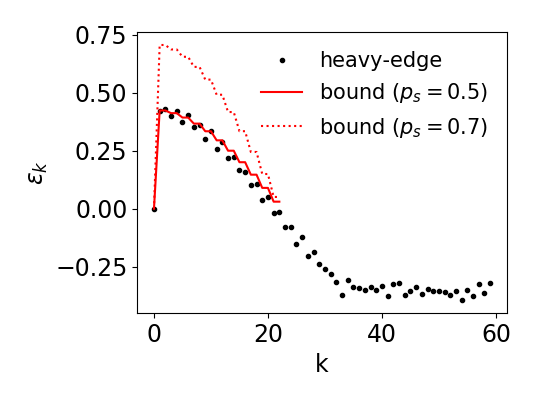

In [18]:
import matplotlib
matplotlib.rcParams.update({'font.size': 17})
    
rss_mean = np.mean(rss, 1)
bound_rss_mean = np.nanmean(bound_rss, 1)

if graph_name == 'swissroll': kmax = 100
elif graph_name == 'bunny': kmax = 60
elif graph_name == 'regular': kmax = 60
elif graph_name == 'yeast': kmax = 1100
else: print('WARNING: unknown graph type')
    
size = 1.34
fig, axes = plt.subplots(1, 1, figsize=(4*size, 3.0*size))

for iteration in range(iterations):
    if iteration == 0:
        axes.plot( rss[0:kmax,iteration], 'ko', label='heavy-edge', markersize=3)
    else:
        axes.plot( rss[0:kmax,iteration], 'ko', markersize=3)            

axes.plot( bound_rss_mean[0:kmax, 0], '-', color='r', label= 'bound ($p_s=' + str(p_success[0]) + '$)')          
axes.plot( bound_rss_mean[0:kmax, 1], ':', color='r', label= 'bound ($p_s=' + str(p_success[1]) + '$)')          

axes.set_xlabel('k')    
axes.set_ylabel('$\epsilon_k$')  
legend0 = axes.legend(fontsize=15, loc='upper right', edgecolor=[1,1,1])
plt.tight_layout()
        